## Imports

In [84]:
import pandas as pd
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import numpy as np
import tqdm

## Data Exploration

In [85]:
training_set = pd.read_csv("data/train.csv")
testing_set = pd.read_csv("data/test.csv")

X_train = training_set.iloc[:, 1:]
y_train = pd.read_csv("data/labels.csv").iloc[:, 1:]
X_test = testing_set.iloc[:, 1:]
test_ids = testing_set.iloc[:, 0]

X_train.head()

,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,...,Age,Education,Income,BMI_Category,Healthy_Diet,Mental_Health_Risk,Heart_Disease_Risk,Age_Group,Education_Level,Income_Group
0,0,1,1,20.693674,1,0,0,1,1,1,...,11.725312,6.0,8.0,Normal weight,1,0,2,Young,Some College,High Income
1,0,0,1,28.375985,0,0,0,1,0,1,...,7.977719,5.0,8.0,Obese,0,0,0,Young,Some College,High Income
2,1,1,1,24.629353,0,0,0,1,1,1,...,8.161838,5.0,6.0,Normal weight,1,0,2,Young,Some College,Middle Income
3,0,1,1,27.246610,0,0,0,1,1,1,...,5.038298,6.0,7.0,Overweight,1,0,1,Young,Some College,High Income
4,0,1,1,23.671678,0,0,0,1,1,1,...,12.037360,4.0,6.0,Normal weight,1,0,1,Young,High School Graduate,Middle Income


In [86]:
print("NaN values in training set:", X_train.isna().sum().sum())
print("NaN values in testing set:", X_test.isna().sum().sum())

NaN values in training set: 0
NaN values in testing set: 0


In [87]:
X_train.iloc[:, :14].describe()

,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,AnyHealthcare,NoDocbcCost,GenHlth
count,202944.000000,202944.000000,202944.000000,202944.000000,202944.000000,202944.000000,202944.000000,202944.000000,202944.000000,202944.000000,202944.000000,202944.000000,202944.000000,202944.000000
mean,0.428212,0.423664,0.962748,28.367242,0.442866,0.040578,0.094238,0.757081,0.634407,0.811766,0.056178,0.951026,0.084107,2.511831
std,0.494821,0.494140,0.189378,6.284137,0.496726,0.197310,0.292160,0.428848,0.481597,0.390900,0.230266,0.215814,0.277549,1.068240
min,0.000000,0.000000,0.000000,11.665176,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,0.000000,1.000000,24.384518,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,2.000000
50%,0.000000,0.000000,1.000000,27.897453,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,2.000000
75%,1.000000,1.000000,1.000000,30.742114,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,3.000000
max,1.000000,1.000000,1.000000,98.446163,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,5.000000


In [ ]:
X_train["MentHlth"] = X_train["MentHlth"].clip(0, 30)
X_train["PhysHlth"] = X_train["PhysHlth"].clip(0, 30)
X_train.iloc[:, 14:].describe()

,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income,Healthy_Diet,Mental_Health_Risk,Heart_Disease_Risk
count,202944.000000,202944.000000,202944.000000,202944.000000,202944.000000,202944.000000,202944.000000,202944.000000,202944.000000,202944.000000
mean,3.193190,4.248751,0.168303,0.440427,8.044885,5.146272,6.147045,0.562988,0.189619,1.429557
std,7.435053,8.731686,0.374136,0.496440,2.900076,0.977706,1.986224,0.496018,0.392000,1.150272
min,-1.678270,-1.882606,0.000000,0.000000,0.399947,1.000000,1.000000,0.000000,0.000000,0.000000
25%,-0.131736,-0.115747,0.000000,0.000000,6.134075,4.000000,5.000000,0.000000,0.000000,1.000000
50%,0.218025,0.348222,0.000000,0.000000,8.161838,5.000000,7.000000,1.000000,0.000000,1.000000
75%,1.965709,3.012428,0.000000,1.000000,10.029736,6.000000,8.000000,1.000000,0.000000,2.000000
max,31.249029,31.858730,1.000000,1.000000,13.541879,6.000000,8.000000,1.000000,1.000000,5.000000


**Observation:** Mental health and physical health should be an integer in range [0, 30]. This is not the case in the data. Will it affect model performance? Should we correct this?

In [89]:
X_train.describe(include='object')

,BMI_Category,Age_Group,Education_Level,Income_Group
count,202944,202944,202944,202944
unique,4,1,3,3
top,Overweight,Young,Some College,High Income
freq,75064,202944,141754,106875


In [90]:
X_test.describe(include='object')

,BMI_Category,Age_Group,Education_Level,Income_Group
count,50736,50736,50736,50736
unique,4,1,3,3
top,Overweight,Young,Some College,High Income
freq,18685,50736,35481,26729


## Preprocessing

In [91]:
categorical_features = X_train.select_dtypes(include=['object']).columns
numerical_features = [col for col in X_train.select_dtypes(include=['float64', 'int64']).columns if not set(X_train[col]).issubset({0, 1})]

print("Categorical features:", categorical_features)
print("Numerical features:", numerical_features)

Categorical features: Index(['BMI_Category', 'Age_Group', 'Education_Level', 'Income_Group'], dtype='object')
Numerical features: ['BMI', 'GenHlth', 'MentHlth', 'PhysHlth', 'Age', 'Education', 'Income', 'Heart_Disease_Risk']


In [92]:
X_train["MentHlth"] = X_train["MentHlth"].clip(0, 30)
X_train["PhysHlth"] = X_train["PhysHlth"].clip(0, 30)

X_test["MentHlth"] = X_test["MentHlth"].clip(0, 30)
X_test["PhysHlth"] = X_test["PhysHlth"].clip(0, 30)

In [93]:
X_train_processed = pd.get_dummies(X_train, columns=categorical_features)
X_test_processed = pd.get_dummies(X_test, columns=categorical_features)

scaler = StandardScaler()
X_train_processed[numerical_features] = scaler.fit_transform(X_train[numerical_features])
X_test_processed[numerical_features] = scaler.transform(X_test[numerical_features])

X_train_processed.head()

,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,...,BMI_Category_Obese,BMI_Category_Overweight,BMI_Category_Underweight,Age_Group_Young,Education_Level_High School Graduate,Education_Level_No High School,Education_Level_Some College,Income_Group_High Income,Income_Group_Low Income,Income_Group_Middle Income
0,0,1,1,-1.221104,1,0,0,1,1,1,...,False,False,False,True,False,False,True,True,False,False
1,0,0,1,0.001391,0,0,0,1,0,1,...,True,False,False,True,False,False,True,True,False,False
2,1,1,1,-0.594815,0,0,0,1,1,1,...,False,False,False,True,False,False,True,False,False,True
3,0,1,1,-0.178328,0,0,0,1,1,1,...,False,True,False,True,False,False,True,True,False,False
4,0,1,1,-0.747211,0,0,0,1,1,1,...,False,False,False,True,True,False,False,False,False,True


### Remove unecessary features

In [94]:
# from sklearn.feature_selection import mutual_info_classif
# pd.set_option('display.max_columns', 100)
# # Compute mutual information for  ranking of features
# mutual_info = mutual_info_classif(X_train_processed, y_train.squeeze())
# feature_importance = pd.Series(mutual_info, index=X_train_processed.columns).sort_values(ascending=False)
# print('features before')
# print(X_train_processed.columns)
# print('features importance')
# print(feature_importance)

# # Select top N features based on importance
# top_features = feature_importance[feature_importance > 0.02].index
# X_train_processed = X_train_processed[top_features]
# X_test_processed = X_test_processed[top_features]

# print('\ntop features')
# print(len(top_features))

## Neural Network

In [95]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset

from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek

In [96]:
torch.manual_seed(197331)
X_train_nn, X_val_nn, y_train_nn, y_val_nn = train_test_split(X_train_processed, y_train, shuffle=True, test_size=0.2, random_state=0)

In [97]:
# print("Class distribution before SMOTE:")
# print(y_train.value_counts())

# smote = SMOTETomek(random_state=139, sampling_strategy=0.3)
# X_train_nn, y_train_nn = smote.fit_resample(X_train_nn, y_train_nn.squeeze())

# print("Class distribution after SMOTE:")
# print(pd.Series(y_train_nn).value_counts())

In [98]:
class NeuralNetworkDataset(Dataset):
    def __init__(self, X, y):
      self.X = torch.tensor(X.values.astype(float), dtype=torch.float32)
      self.y = torch.tensor(y.values.astype(float), dtype=torch.float32).reshape(-1, 1)
      self.X = Variable(self.X).float()
      self.y = Variable(self.y).float()

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

training_data = NeuralNetworkDataset(X_train_nn, y_train_nn)
validation_data = NeuralNetworkDataset(X_val_nn, y_val_nn)

train_dataloader = DataLoader(training_data, batch_size=1024)
val_dataloader = DataLoader(validation_data, batch_size=1024)

training_data[0]

(tensor([ 0.0000,  0.0000,  1.0000, -0.3408,  1.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  1.0000,  0.0000,  1.0000,  0.0000, -0.4791, -0.1934, -0.4827,
          0.0000,  0.0000,  0.3363, -0.1496,  0.9329,  0.0000,  0.0000, -0.3734,
          0.0000,  0.0000,  1.0000,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000,
          1.0000,  0.0000,  0.0000]),
 tensor([0.]))

In [ ]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        # NO DROPOUT
        # self.linear_relu_stack = nn.Sequential(
        #   nn.Linear(X_train_nn.shape[1], 2000),
        #   nn.LeakyReLU(),
        #   nn.Linear(2000, 1000),
        #   nn.LeakyReLU(),
        #   nn.Linear(1000, 1000),
        #   nn.LeakyReLU(),
        #   nn.Linear(1000, 1),
        #   nn.Sigmoid(),
        # )

        # WITH DROPOUT
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(X_train_nn.shape[1], 2000),
            nn.ReLU(),
            nn.BatchNorm1d(2000),
            nn.Dropout(0.2),
            nn.Linear(2000, 1000),
            nn.ReLU(),
            nn.BatchNorm1d(1000),
            nn.Linear(1000, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return self.linear_relu_stack(x)
    
    def _initialize_weights(self):
        for m in self.linear_relu_stack:
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)  # Use Xavier uniform
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

model = NeuralNetwork()
model

NeuralNetwork(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=35, out_features=2000, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(2000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=2000, out_features=1000, bias=True)
    (5): ReLU()
    (6): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Linear(in_features=1000, out_features=1, bias=True)
    (8): Sigmoid()
  )
)

In [100]:
# # class weights

# from sklearn.utils.class_weight import compute_class_weight
# import numpy as np

# class_weights = compute_class_weight(
#     class_weight='balanced',
#     classes=np.unique(y_train_nn),
#     y=y_train_nn.values.ravel()
# )
# class_weights = torch.tensor(class_weights, dtype=torch.float32)

# print("Class weights:", class_weights)


In [101]:
# Source: https://stackoverflow.com/questions/65318064/can-i-trainoptimize-on-f1-score-loss-with-pytorch
def f1_loss(y_true, y_pred):
    tp = torch.sum((y_true * y_pred).float(), dim=0)
    tn = torch.sum(((1 - y_true) * (1 - y_pred)).float(), dim=0)
    fp = torch.sum(((1 - y_true) * y_pred).float(), dim=0)
    fn = torch.sum((y_true * (1 - y_pred)).float(), dim=0)

    p = tp / (tp + fp + 1e-7)
    r = tp / (tp + fn + 1e-7)

    f1 = 2 * p * r / (p + r + 1e-7)
    f1 = torch.where(torch.isnan(f1), torch.zeros_like(f1), f1)
    return 1 - torch.mean(f1)

In [102]:
optimizer = optim.Adam(model.parameters(), lr=2e-5, weight_decay=1e-3)
# loss_fn = f1_loss
loss_fn = nn.BCELoss()
print(optimizer)
print(loss_fn)

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 2e-05
    maximize: False
    weight_decay: 0.001
)
BCELoss()


In [103]:
# For LR decat
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)

### Training

In [104]:
def train(dataloader, model, loss_fn, optimizer):
    model.train()

    for X, y in dataloader:
        pred = model(X)
        loss = loss_fn(pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

In [105]:
train_loss_history = []
train_f1_history = []
val_loss_history = []
val_f1_history = []
def test(training_data, validation_data, model, loss_fn, metric):
    model.eval()
    with torch.no_grad():
        train_pred = model(training_data.X)
        val_pred = model(validation_data.X)
        train_loss = loss_fn(train_pred, training_data.y)
        val_loss = loss_fn(val_pred, validation_data.y)
        train_f1 = metric(training_data.y, train_pred.round())
        val_f1 = metric(validation_data.y, val_pred.round())
        train_loss_history.append(train_loss)
        val_loss_history.append(val_loss)
        train_f1_history.append(train_f1)
        val_f1_history.append(val_f1)
        print(f" TRAIN - Loss={train_loss:>8f}, F1={train_f1:>8f}")
        print(f" VALID - Loss={val_loss:>8f}, F1={val_f1:>8f}")
        return val_f1


Epoch 1:
 TRAIN - Loss=0.647342, F1=0.439643
 VALID - Loss=0.650027, F1=0.434678
 Current Learning Rate: 2e-05
Model saved!


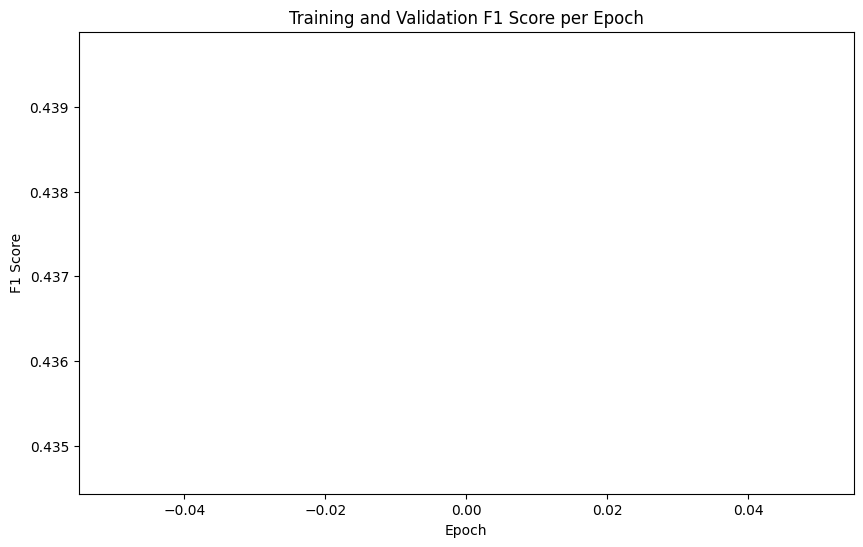


Epoch 2:
 TRAIN - Loss=0.625627, F1=0.452807
 VALID - Loss=0.629329, F1=0.444058
 Current Learning Rate: 2e-05
Model saved!


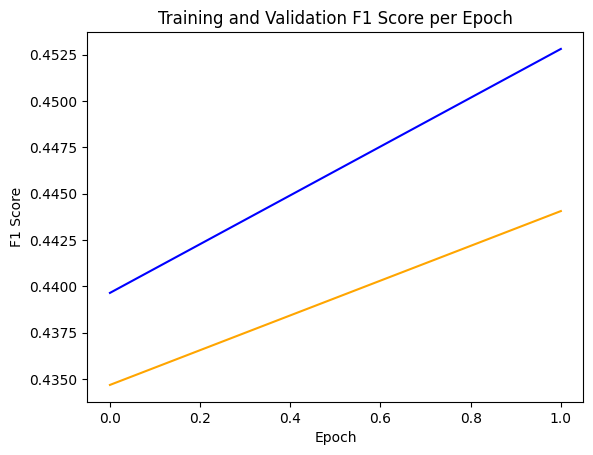


Epoch 3:
 TRAIN - Loss=0.605279, F1=0.461681
 VALID - Loss=0.609867, F1=0.450949
 Current Learning Rate: 2e-05
Model saved!


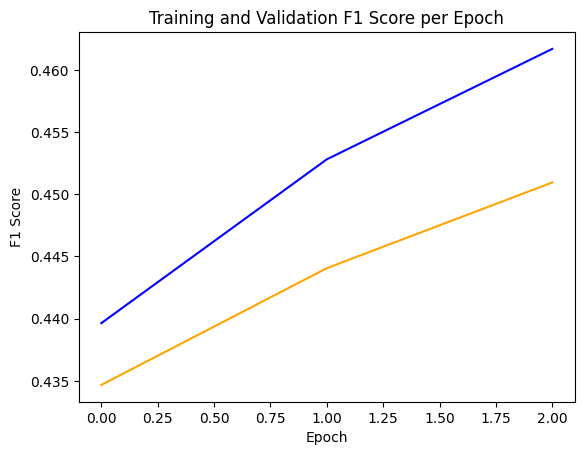


Epoch 4:
 TRAIN - Loss=0.586025, F1=0.467642
 VALID - Loss=0.591599, F1=0.455126
 Current Learning Rate: 2e-05
Model saved!


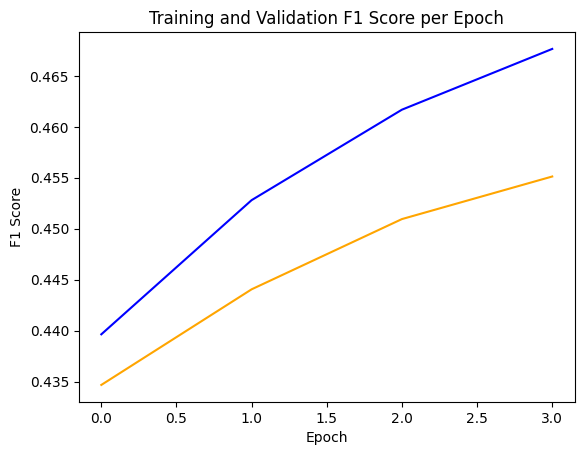


Epoch 5:
 TRAIN - Loss=0.563132, F1=0.474336
 VALID - Loss=0.569476, F1=0.459580
 Current Learning Rate: 2e-05
Model saved!


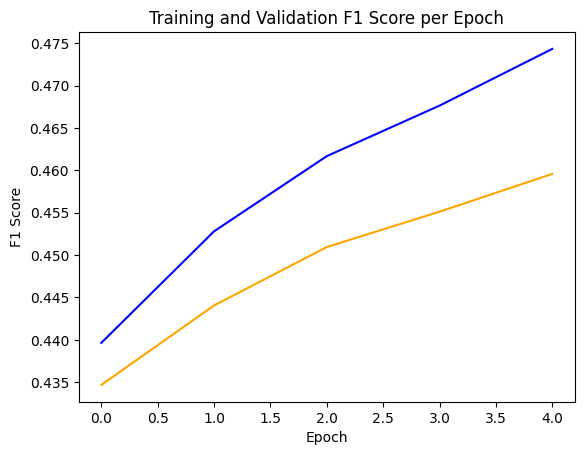


Epoch 6:
 TRAIN - Loss=0.537350, F1=0.480670
 VALID - Loss=0.544728, F1=0.459885
 Current Learning Rate: 2e-05
Model saved!


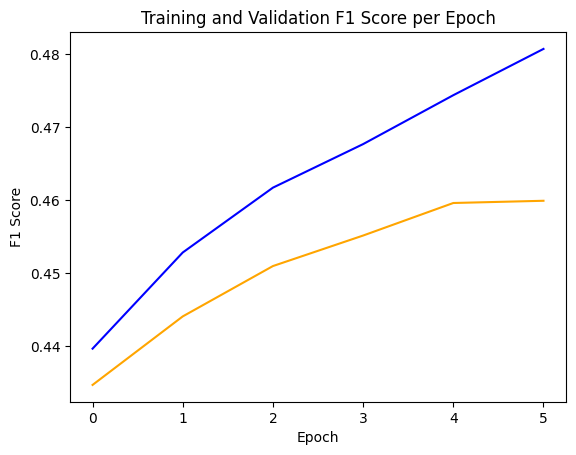


Epoch 7:
 TRAIN - Loss=0.511796, F1=0.486044
 VALID - Loss=0.520470, F1=0.461927
 Current Learning Rate: 2e-05
Model saved!


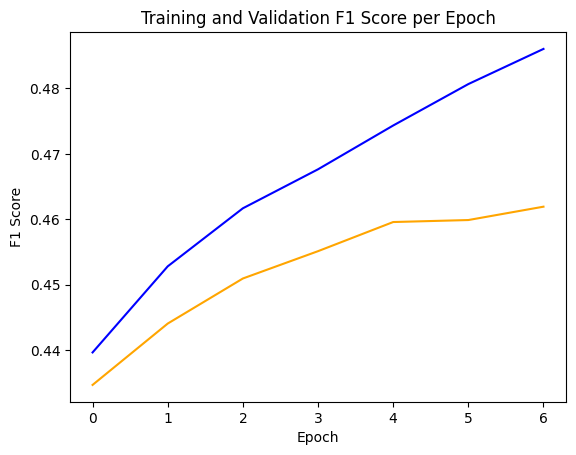


Epoch 8:
 TRAIN - Loss=0.482997, F1=0.487423
 VALID - Loss=0.492790, F1=0.457544
 Current Learning Rate: 2e-05


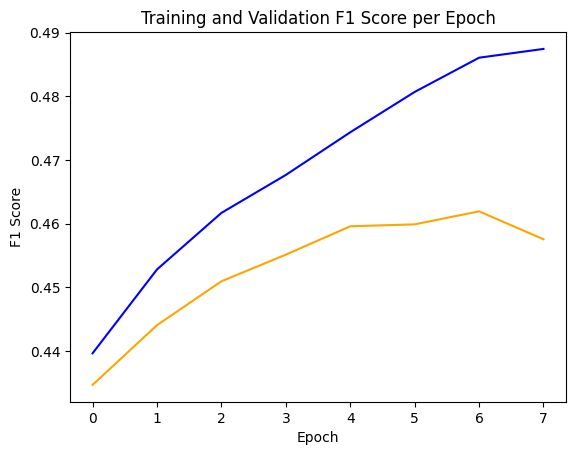


Epoch 9:
 TRAIN - Loss=0.458297, F1=0.487005
 VALID - Loss=0.468936, F1=0.452936
 Current Learning Rate: 2e-05


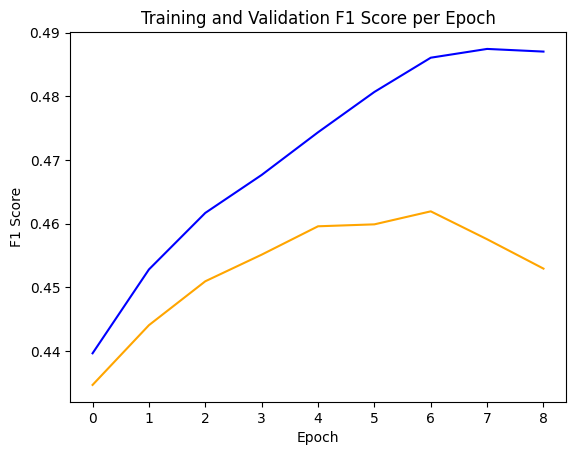


Epoch 10:
 TRAIN - Loss=0.432752, F1=0.484405
 VALID - Loss=0.444688, F1=0.442446
 Current Learning Rate: 2e-05


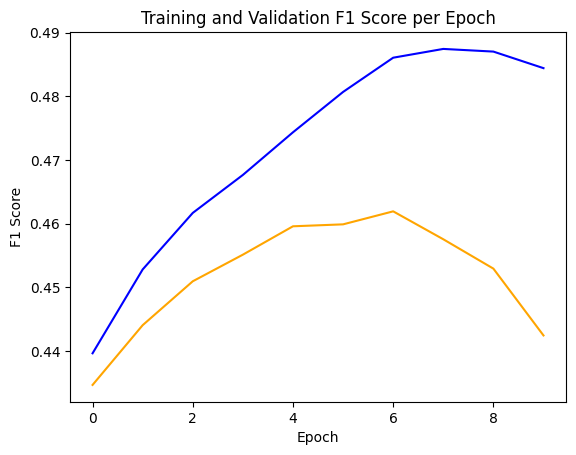


Epoch 11:
 TRAIN - Loss=0.408684, F1=0.476446
 VALID - Loss=0.421682, F1=0.427305
 Current Learning Rate: 2e-05


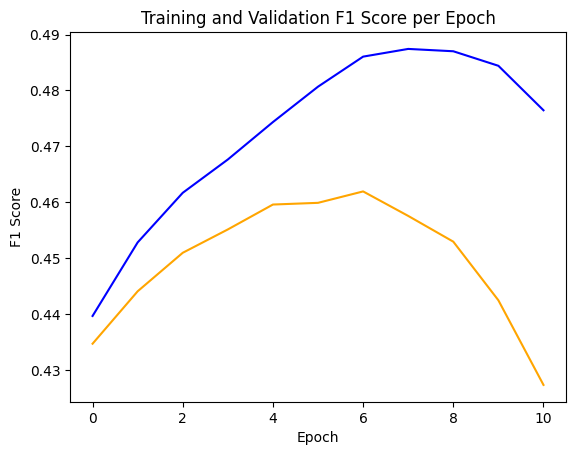


Epoch 12:
 TRAIN - Loss=0.388347, F1=0.467960
 VALID - Loss=0.402562, F1=0.415538
 Current Learning Rate: 2e-05


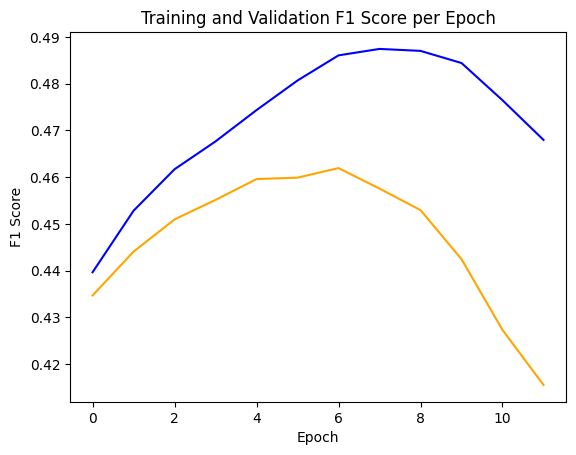


Epoch 13:
 TRAIN - Loss=0.370679, F1=0.457419
 VALID - Loss=0.385814, F1=0.396868
 Current Learning Rate: 2e-05


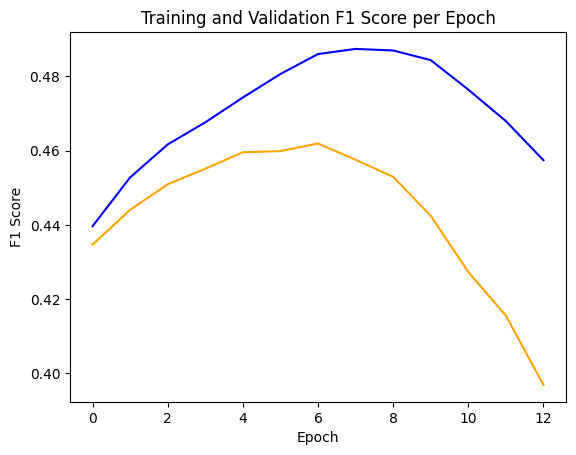


Epoch 14:
 TRAIN - Loss=0.356056, F1=0.448860
 VALID - Loss=0.372289, F1=0.385835
 Current Learning Rate: 2e-05


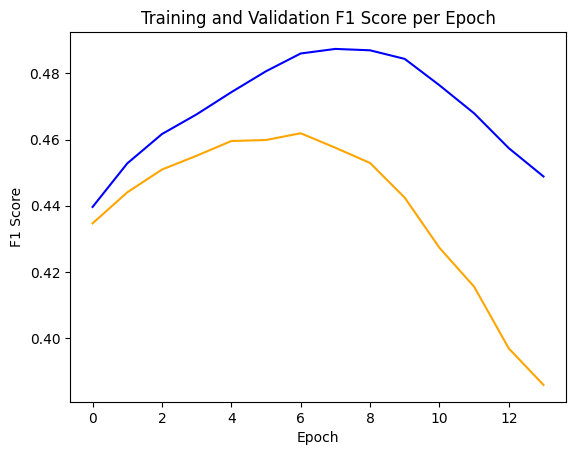


Epoch 15:
 TRAIN - Loss=0.343862, F1=0.436512
 VALID - Loss=0.361200, F1=0.370124
 Current Learning Rate: 2e-05


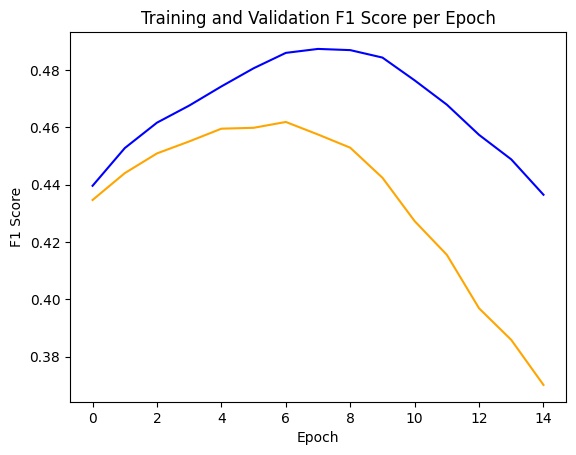


Epoch 16:
 TRAIN - Loss=0.333826, F1=0.434256
 VALID - Loss=0.352357, F1=0.364073
 Current Learning Rate: 2e-05


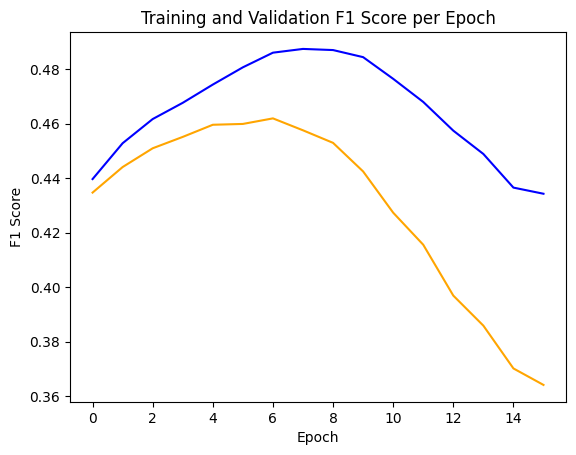


Epoch 17:
 TRAIN - Loss=0.325374, F1=0.417518
 VALID - Loss=0.344489, F1=0.343796
 Current Learning Rate: 2e-05


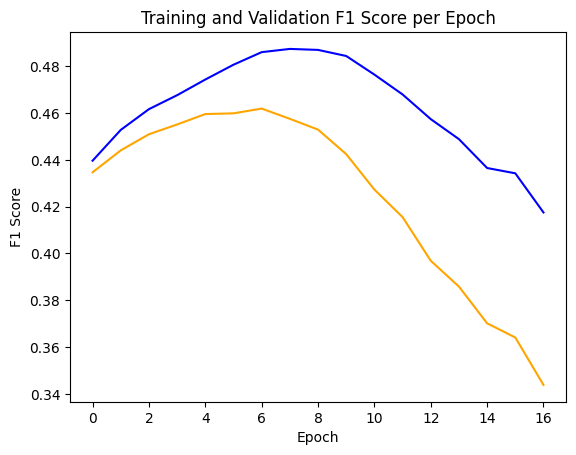


Epoch 18:
 TRAIN - Loss=0.318887, F1=0.409843
 VALID - Loss=0.339172, F1=0.331856
 Current Learning Rate: 2e-05


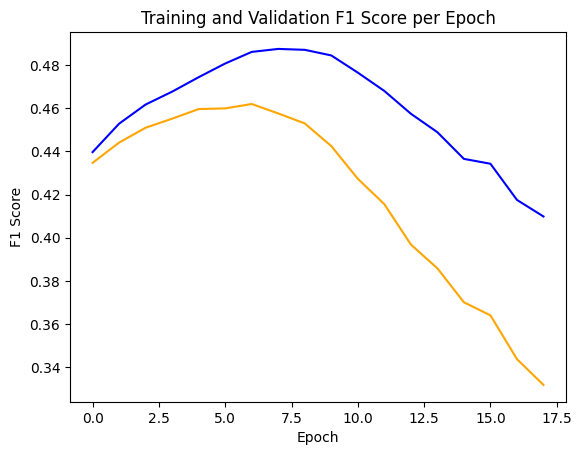


Epoch 19:
 TRAIN - Loss=0.313015, F1=0.403079
 VALID - Loss=0.334192, F1=0.326608
 Current Learning Rate: 2e-05


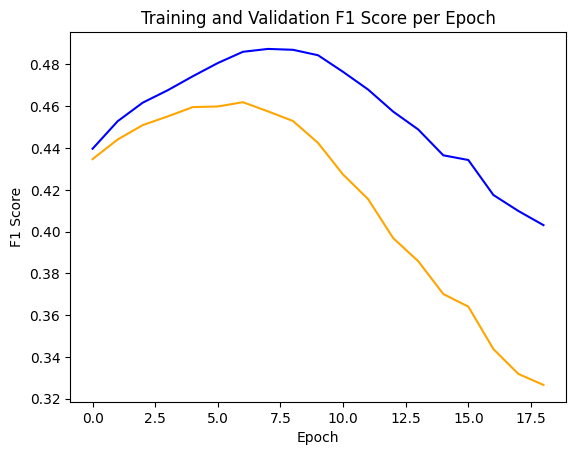


Epoch 20:
 TRAIN - Loss=0.308604, F1=0.403422
 VALID - Loss=0.330885, F1=0.322480
 Current Learning Rate: 2.0000000000000003e-06


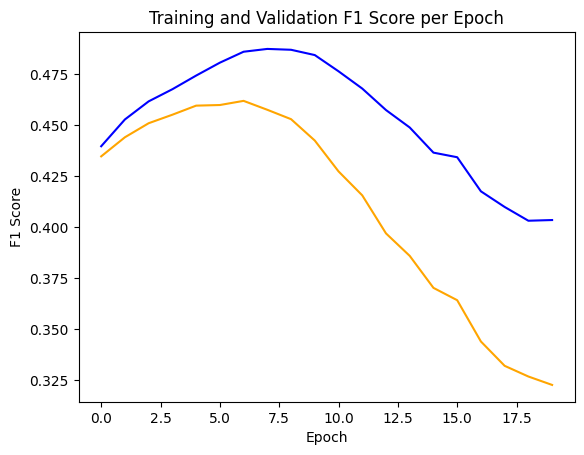


Epoch 21:


KeyboardInterrupt: 

In [106]:
# model._initialize_weights()
best_val_f1 = 0.0

plt.figure(figsize=(10, 6))

for t in range(200):
    print(f"\nEpoch {t+1}:")
    train(train_dataloader, model, loss_fn, optimizer)
    val_f1 = test(training_data, validation_data, model, loss_fn, f1_score)
    
    scheduler.step()
    current_lr = scheduler.get_last_lr()[0]
    print(f" Current Learning Rate: {current_lr}")

    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        torch.save(model.state_dict(), "best_model.pt")
        print("Model saved!")
        
    plt.clf()
    
    plt.plot(train_f1_history, label="Training F1", color="blue")
    plt.plot(val_f1_history, label="Validation F1", color="orange")
    plt.title("Training and Validation F1 Score per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("F1 Score")
    plt.draw()
    plt.pause(0.1)
    plt.show()
        
print("\nTraining completed!")
print("Best validation F1:", best_val_f1)

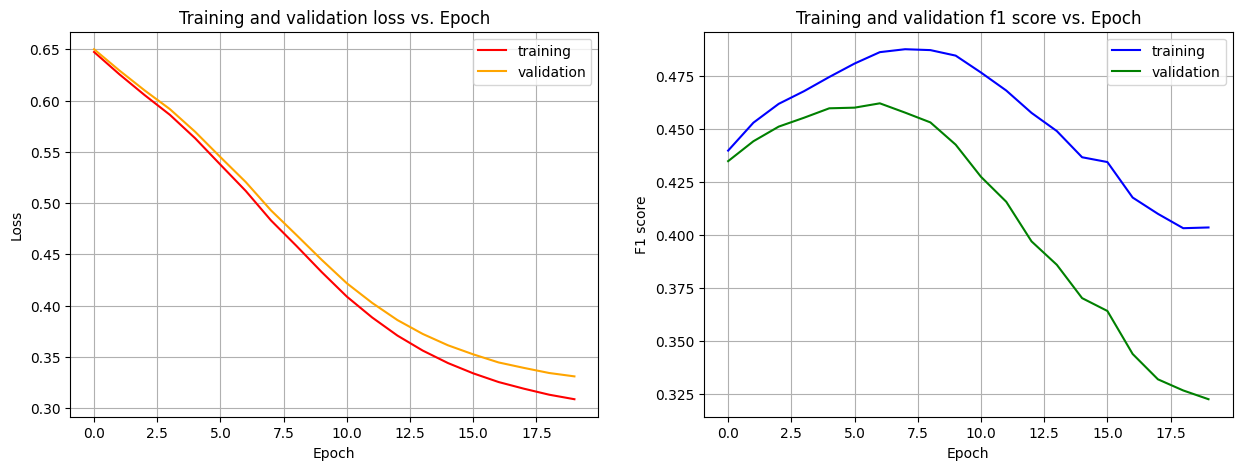

In [107]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].plot(train_loss_history, color="red", label="training")
axes[0].plot(val_loss_history, color="orange", label="validation")
axes[0].set_title('Training and validation loss vs. Epoch')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].grid()
axes[0].legend()

axes[1].plot(train_f1_history, color="blue", label="training")
axes[1].plot(val_f1_history, color="green", label="validation")
axes[1].set_title('Training and validation f1 score vs. Epoch')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('F1 score')
axes[1].grid()
axes[1].legend()

plt.show()

In [ ]:
model = NeuralNetwork()
model.load_state_dict(torch.load("best_model.pt", weights_only=True))
test(training_data, validation_data, model, loss_fn, f1_score)

In [ ]:
X_test_nn = Variable(torch.tensor(X_test_processed.values.astype(float), dtype=torch.float32)).float()
predictions = model(X_test_nn).round().detach().numpy().reshape(-1)
predictions = predictions.astype(int)
predictions

## Submission

In [ ]:
output = pd.DataFrame({
  'index': test_ids,
  'Diabetes_binary': predictions,
})
output.to_csv('submission.csv', index=False)
output